In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Name:", gpu.name, "  Type:", gpu.device_type)

    except RuntimeError as e:
        print(e)

Name: /physical_device:GPU:0   Type: GPU


In [2]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle as skshuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from sklearn import preprocessing
from pylab import rcParams
%matplotlib inline

In [3]:
np.__version__

'1.18.5'

In [4]:
tf.__version__

'2.4.1'

In [5]:
rcParams['figure.figsize'] = 50, 10

In [6]:
PATH_TO_TEST_TRAIN_DATA = 'Tangni/Data/'

In [11]:
class LSTM_Tangni:
    def __init__(self,dictionary):
        
        self.train_size = 62
        
        
        self.data1 = np.array(pd.read_csv(PATH_TO_TEST_TRAIN_DATA + '1-3.csv',  header=0, usecols=[0, 1, 2, 3], index_col=None))
        self.data2 = np.array(pd.read_csv(PATH_TO_TEST_TRAIN_DATA + '2-12.csv', header=0, usecols=[0, 1, 2, 3], index_col=None))
        self.data3 = np.array(pd.read_csv(PATH_TO_TEST_TRAIN_DATA + '3-6.csv',  header=0, usecols=[0, 1, 2, 3], index_col=None))
        self.data4 = np.array(pd.read_csv(PATH_TO_TEST_TRAIN_DATA + '4-15.csv', header=0, usecols=[0, 1, 2, 3], index_col=None))
        self.data5 = np.array(pd.read_csv(PATH_TO_TEST_TRAIN_DATA + '5-15.csv', header=0, usecols=[0, 1, 2, 3], index_col=None))
        
        if (dictionary['normalize'] == 1):
            Data = np.append(self.data1,np.append(self.data2,np.append(self.data3,np.append(self.data4, self.data5,axis=0), axis=0), axis=0) ,axis=0)
            Data = preprocessing.normalize(Data, axis=0)
            self.data1 = Data[:int(len(Data)/5)]
            self.data2 = Data[int(len(Data)/5):int(len(Data)/5)*2]
            self.data3 = Data[int(len(Data)/5)*2:int(len(Data)/5)*3]
            self.data4 = Data[int(len(Data)/5)*3:int(len(Data)/5)*4]
            self.data5 = Data[int(len(Data)/5)*4:]
    
       
        
    def Print(self):
        print(self.data1)
        
    def rmse(self, true, predict):
        
        r = true - predict
        sq = r*r
        avg = np.mean(sq)
        error = math.sqrt(avg)

        return error
    
    def Average(self, lst):
        return sum(lst) / len(lst)
    
    def dataProcessing(self, dF, lookback):
    
        data=list()
        label=list()
        for i in range(len(dF) - lookback):

            data.append(np.array(dF[i:i+lookback,:4]))

            label.append(np.array(dF[i+lookback,1:2]))
        
        return np.array(data), np.array(label)

    def make_packets(self, lookback):
        
        X1, L1 = self.dataProcessing(self.data1, lookback)
        X2, L2 = self.dataProcessing(self.data2, lookback)
        X3, L3 = self.dataProcessing(self.data3, lookback)
        X4, L4 = self.dataProcessing(self.data4, lookback)
        X5, L5 = self.dataProcessing(self.data5, lookback)
        
        train_X1, label_X1,test_X1,tst_label_X1 = X1[:self.train_size - lookback], L1[:self.train_size - lookback], X1[self.train_size - lookback:], L1[self.train_size - lookback:]
        train_X2, label_X2,test_X2,tst_label_X2 = X2[:self.train_size - lookback], L2[:self.train_size - lookback], X2[self.train_size - lookback:], L2[self.train_size - lookback:]
        train_X3, label_X3,test_X3,tst_label_X3 = X3[:self.train_size - lookback], L3[:self.train_size - lookback], X3[self.train_size - lookback:], L3[self.train_size - lookback:]
        train_X4, label_X4,test_X4,tst_label_X4 = X4[:self.train_size - lookback], L4[:self.train_size - lookback], X4[self.train_size - lookback:], L4[self.train_size - lookback:]
        train_X5, label_X5,test_X5,tst_label_X5 = X5[:self.train_size - lookback], L5[:self.train_size - lookback], X5[self.train_size - lookback:], L5[self.train_size - lookback:]
        
    
        return train_X1, label_X1,test_X1,tst_label_X1, train_X2, label_X2,test_X2,tst_label_X2,train_X3, label_X3,test_X3,tst_label_X3, train_X4, label_X4,test_X4,tst_label_X4, train_X5, label_X5,test_X5,tst_label_X5

    def LSTM_model(self, units, lookback):
        
        model = Sequential()
        model.add(LSTM(units = units, return_sequences = False, activation= 'tanh', input_shape = (lookback,4)))

        model.add(Dense(units = 1, activation= 'tanh'))
        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
#         model.summary()
        
        return model
    
    def trainModel(self, units, lookback = 1, batch_size = 4, shuffle = 0):
        
        train_X1, label_X1,test_X1,tst_label_X1, train_X2, label_X2,test_X2,tst_label_X2,train_X3, label_X3,test_X3,tst_label_X3, train_X4, label_X4,test_X4,tst_label_X4, train_X5, label_X5,test_X5,tst_label_X5 = self.make_packets(lookback)
        DATA = [train_X1, label_X1,test_X1,tst_label_X1, train_X2, label_X2,test_X2,tst_label_X2,train_X3, label_X3,test_X3,tst_label_X3, train_X4, label_X4,test_X4,tst_label_X4, train_X5, label_X5,test_X5,tst_label_X5]
        
        Train = np.append(train_X1, np.append(train_X2, np.append(train_X3, np.append(train_X4, train_X5, axis=0), axis=0), axis=0), axis=0)
        Label = np.append(label_X1, np.append(label_X2, np.append(label_X3, np.append(label_X4, label_X5, axis=0), axis=0), axis=0), axis=0) 
     
        if (shuffle == 1):
            Train, Label = skshuffle(Train, Label, random_state=0)
            
        LSTM = self.LSTM_model(units, lookback)
        LSTM.fit(Train, Label, epochs = 10, batch_size = batch_size, verbose=0)
        
        RMSE = list()
        
        #Calculate the error of the traing and testing
        for i in range(0, 20, 2):
            
            prediction = LSTM.predict(DATA[i])
            RMSE.append(round(self.rmse(prediction, DATA[i+1]), 3))
           
         
        #Find average of the training and testing
        RMSE.append(round(self.Average(RMSE[0:5]), 3))
        RMSE.append(round(self.Average(RMSE[5:10]), 3))
        
      
        return RMSE
    
    def runModel(self, units, lookback = 1, batch_size = 4, shuffle = 0):
        
        train_X1, label_X1,test_X1,tst_label_X1, train_X2, label_X2,test_X2,tst_label_X2,train_X3, label_X3,test_X3,tst_label_X3, train_X4, label_X4,test_X4,tst_label_X4, train_X5, label_X5,test_X5,tst_label_X5 = self.make_packets(lookback)
        DATA = [train_X1, label_X1,test_X1,tst_label_X1, train_X2, label_X2,test_X2,tst_label_X2,train_X3, label_X3,test_X3,tst_label_X3, train_X4, label_X4,test_X4,tst_label_X4, train_X5, label_X5,test_X5,tst_label_X5]
        
        Train = np.append(train_X1, np.append(train_X2, np.append(train_X3, np.append(train_X4, train_X5, axis=0), axis=0), axis=0), axis=0)
        Label = np.append(label_X1, np.append(label_X2, np.append(label_X3, np.append(label_X4, label_X5, axis=0), axis=0), axis=0), axis=0) 
     
        if (shuffle == 1):
            Train, Label = skshuffle(Train, Label, random_state=0)
        
        LSTM = self.LSTM_model(units, lookback)
        
        LSTM.fit(Train, Label, epochs = 1000, batch_size = batch_size, verbose=0)
        
        RMSE = list()
        
        #Calculate the error of the traing and testing
        for i in range(0, 20, 2):
            
            prediction = LSTM.predict(DATA[i])
            RMSE.append(round(self.rmse(prediction, DATA[i+1]), 3))
            plt.plot(prediction )
            plt.plot(DATA[i+1], color='r')
            plt.xticks(fontsize=25)
            plt.yticks(fontsize=25)
            plt.show()
         
        #Find average of the training and testing
        RMSE.append(round(self.Average(RMSE[0:5]), 3))
        RMSE.append(round(self.Average(RMSE[5:10]), 3))
        
      
        return RMSE
            

In [12]:
dictionary = {'normalize': 1}

In [13]:
lstm = LSTM_Tangni(dictionary)

In [14]:
lookback = [1,2,3,4,5]
batch_size = [1,2,4,8,16,32,64]
shuffle = [0,1]
units = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [261]:
Parameters = []
Performance =[]
minimum = 100
idx = 0
minidx = 0

for i in lookback:
    for j in batch_size:
        for k in shuffle:
            for u in units:
            
                Parameters.append([u,i,j,k])
                per = lstm.trainModel(units = u, lookback = i, batch_size = j, shuffle = k)
                Performance.append(per)
                
                print([u,i,j,k],per[-2:])
                
                if per[-2] < minimum:
                    minimum = per[-2]
                    minidx = idx
                    
                idx += 1
                
print('--------------------------------------------------')
print('Minimimu Error at')
print(Parameters[minidx])
print(Performance[minidx])

[10, 1, 4, 0] [0.006, 0.01]
[50, 1, 4, 0] [0.006, 0.01]
[100, 1, 4, 0] [0.006, 0.012]
[150, 1, 4, 0] [0.005, 0.01]
[200, 1, 4, 0] [0.005, 0.01]
[250, 1, 4, 0] [0.01, 0.013]
[300, 1, 4, 0] [0.005, 0.011]
[350, 1, 4, 0] [0.004, 0.011]
[400, 1, 4, 0] [0.006, 0.01]
[450, 1, 4, 0] [0.005, 0.011]
[500, 1, 4, 0] [0.006, 0.01]
[10, 1, 4, 1] [0.007, 0.011]
[50, 1, 4, 1] [0.005, 0.011]
[100, 1, 4, 1] [0.006, 0.01]
[150, 1, 4, 1] [0.006, 0.012]
[200, 1, 4, 1] [0.005, 0.012]
[250, 1, 4, 1] [0.006, 0.01]
[300, 1, 4, 1] [0.006, 0.01]
[350, 1, 4, 1] [0.005, 0.012]
[400, 1, 4, 1] [0.004, 0.01]
[450, 1, 4, 1] [0.006, 0.01]
[500, 1, 4, 1] [0.005, 0.01]
[10, 1, 8, 0] [0.015, 0.015]
[50, 1, 8, 0] [0.007, 0.01]
[100, 1, 8, 0] [0.007, 0.01]
[150, 1, 8, 0] [0.005, 0.01]
[200, 1, 8, 0] [0.007, 0.011]
[250, 1, 8, 0] [0.006, 0.01]
[300, 1, 8, 0] [0.007, 0.01]
[350, 1, 8, 0] [0.005, 0.01]
[400, 1, 8, 0] [0.006, 0.01]
[450, 1, 8, 0] [0.005, 0.01]
[500, 1, 8, 0] [0.005, 0.01]
[10, 1, 8, 1] [0.017, 0.017]
[50, 1, 8

[450, 3, 16, 0] [0.007, 0.012]
[500, 3, 16, 0] [0.01, 0.016]
[10, 3, 16, 1] [0.019, 0.018]
[50, 3, 16, 1] [0.008, 0.013]
[100, 3, 16, 1] [0.008, 0.015]
[150, 3, 16, 1] [0.008, 0.016]
[200, 3, 16, 1] [0.006, 0.014]
[250, 3, 16, 1] [0.006, 0.014]
[300, 3, 16, 1] [0.006, 0.014]
[350, 3, 16, 1] [0.007, 0.013]
[400, 3, 16, 1] [0.006, 0.014]
[450, 3, 16, 1] [0.006, 0.013]
[500, 3, 16, 1] [0.007, 0.012]
[10, 3, 32, 0] [0.032, 0.029]
[50, 3, 32, 0] [0.009, 0.013]
[100, 3, 32, 0] [0.007, 0.013]
[150, 3, 32, 0] [0.006, 0.014]
[200, 3, 32, 0] [0.007, 0.015]
[250, 3, 32, 0] [0.007, 0.015]
[300, 3, 32, 0] [0.007, 0.014]
[350, 3, 32, 0] [0.008, 0.015]
[400, 3, 32, 0] [0.008, 0.013]
[450, 3, 32, 0] [0.006, 0.013]
[500, 3, 32, 0] [0.007, 0.013]
[10, 3, 32, 1] [0.024, 0.02]
[50, 3, 32, 1] [0.008, 0.014]
[100, 3, 32, 1] [0.007, 0.013]
[150, 3, 32, 1] [0.007, 0.013]
[200, 3, 32, 1] [0.01, 0.013]
[250, 3, 32, 1] [0.007, 0.013]
[300, 3, 32, 1] [0.006, 0.013]
[350, 3, 32, 1] [0.007, 0.015]
[400, 3, 32, 1] [

[200, 5, 64, 1] [0.006, 0.015]
[250, 5, 64, 1] [0.008, 0.014]
[300, 5, 64, 1] [0.009, 0.014]
[350, 5, 64, 1] [0.009, 0.016]
[400, 5, 64, 1] [0.008, 0.014]
[450, 5, 64, 1] [0.008, 0.015]
[500, 5, 64, 1] [0.007, 0.015]
--------------------------------------------------
Minimimu Error at
[350, 1, 4, 0]
[0.015, 0.004, 0.002, 0.0, 0.001, 0.011, 0.005, 0.003, 0.014, 0.02, 0.004, 0.011]


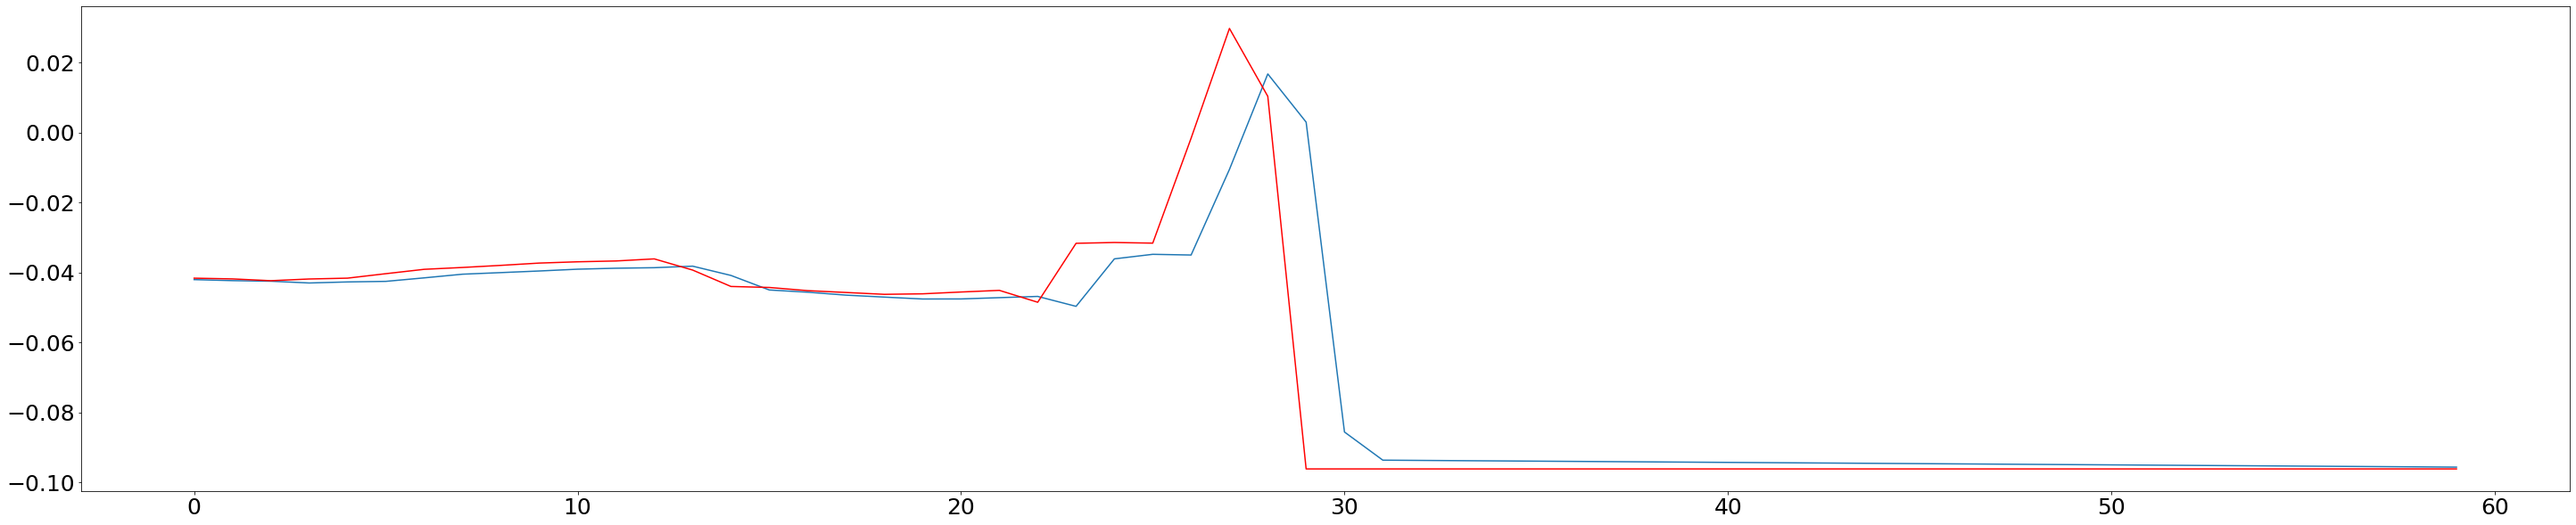

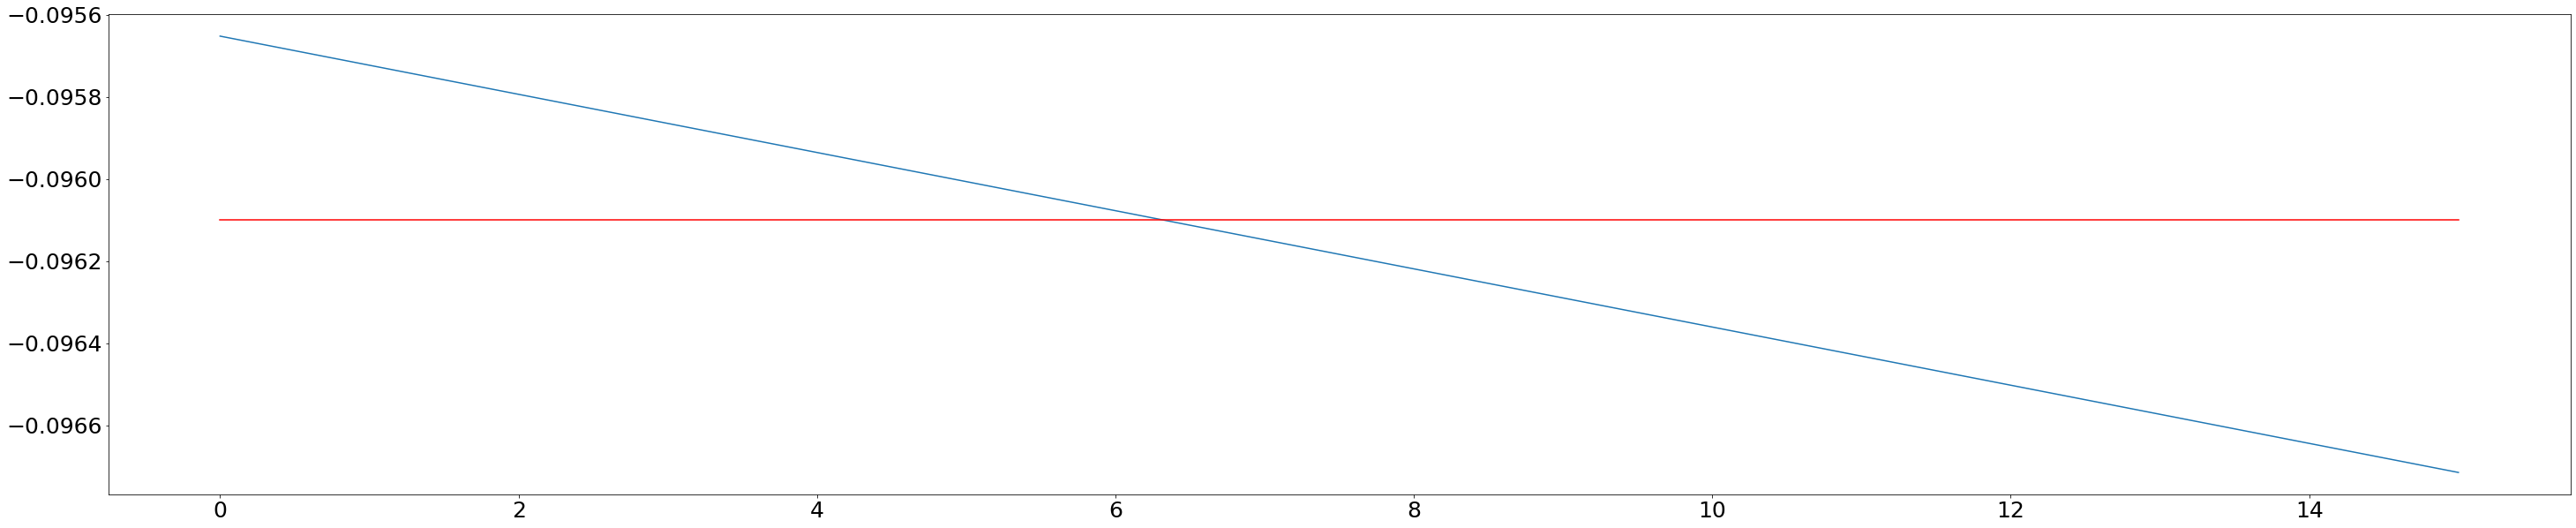

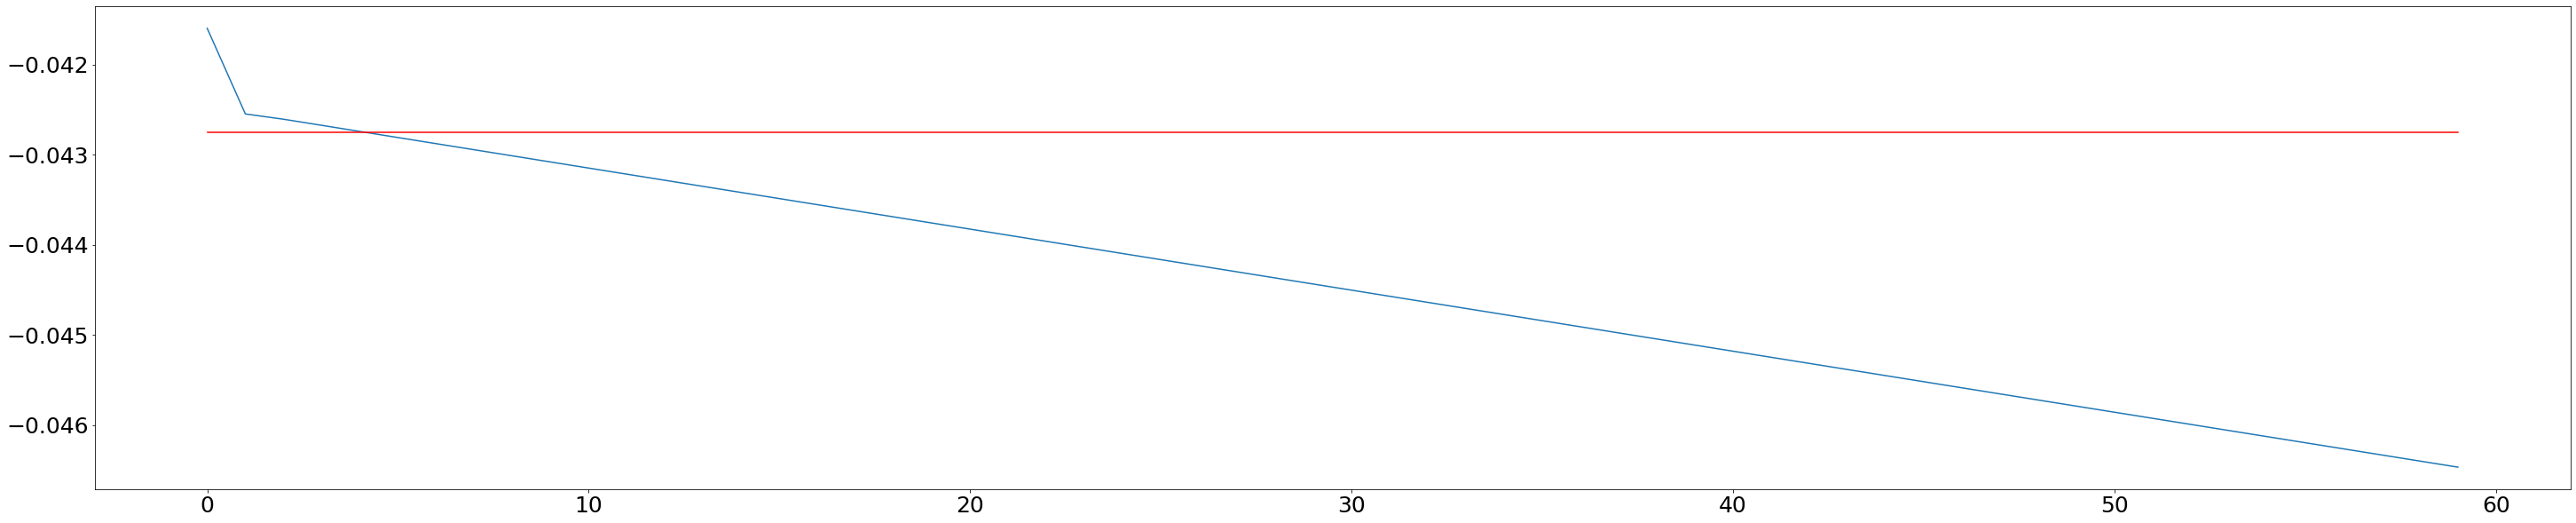

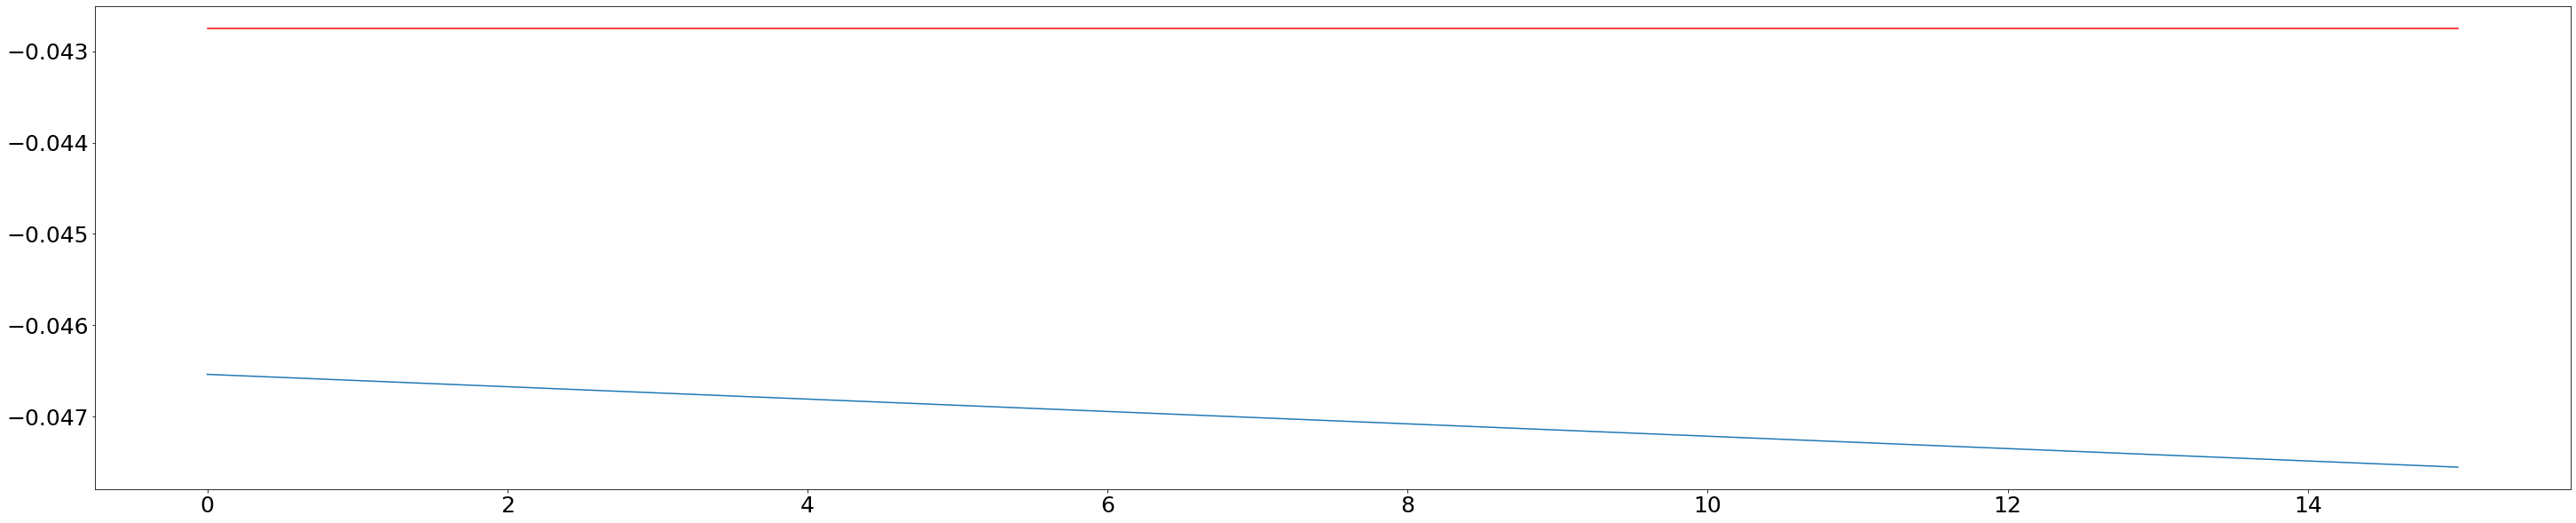

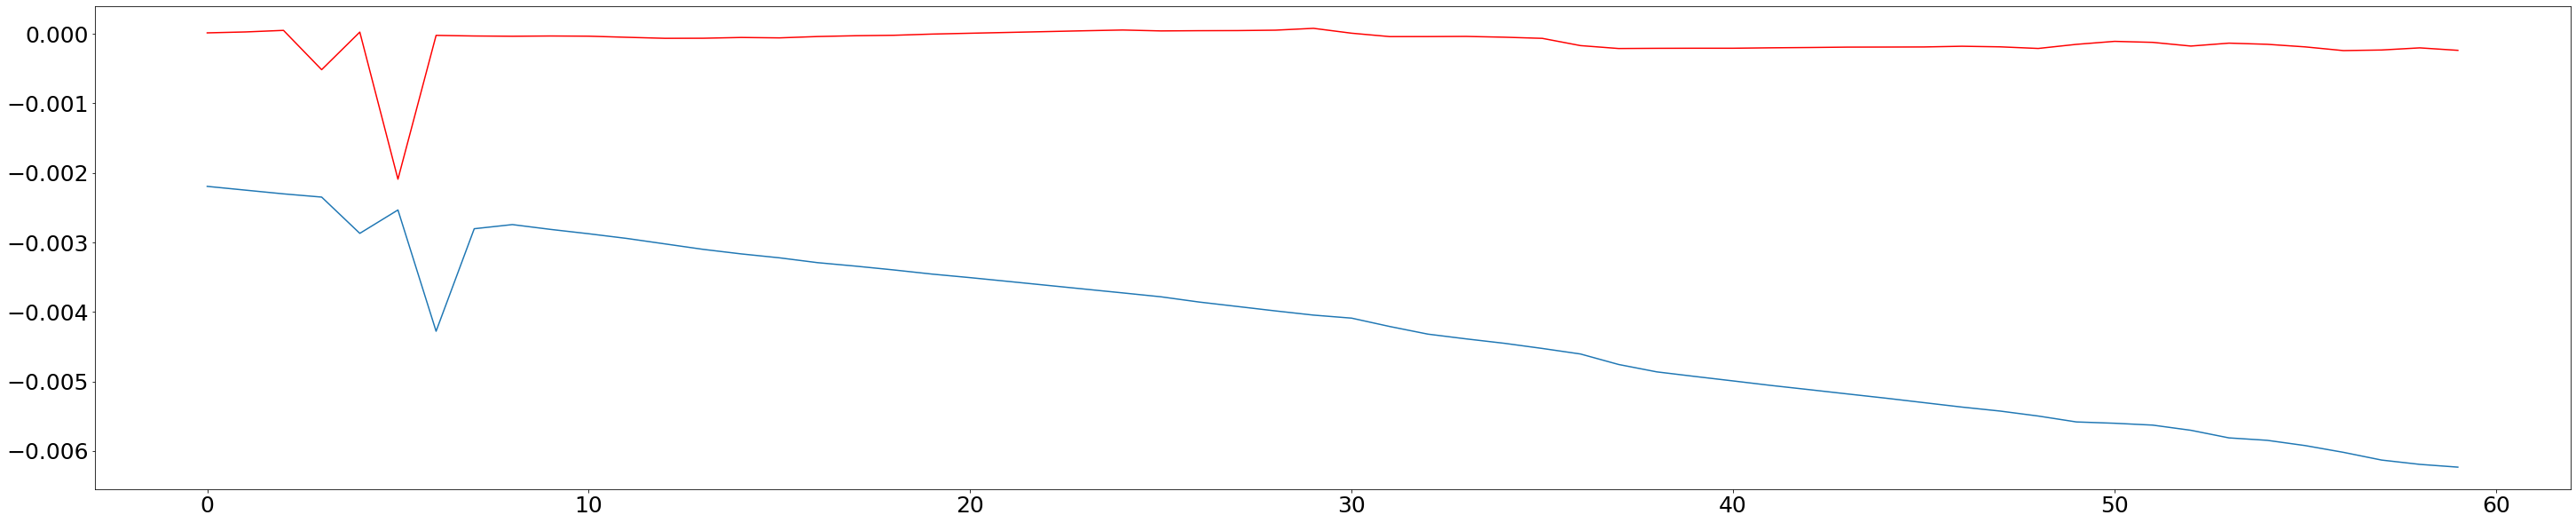

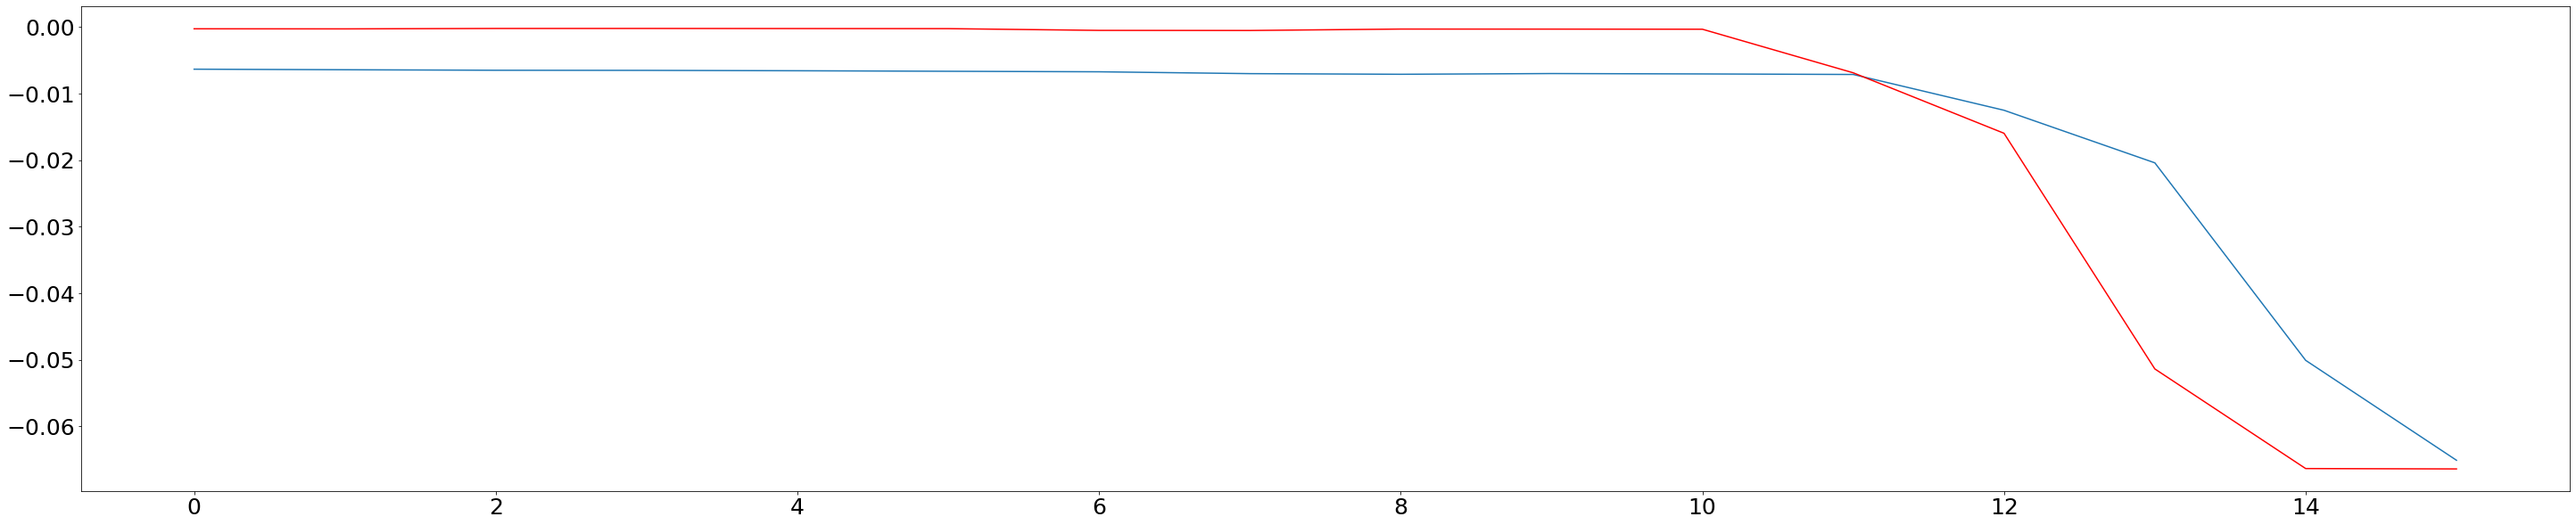

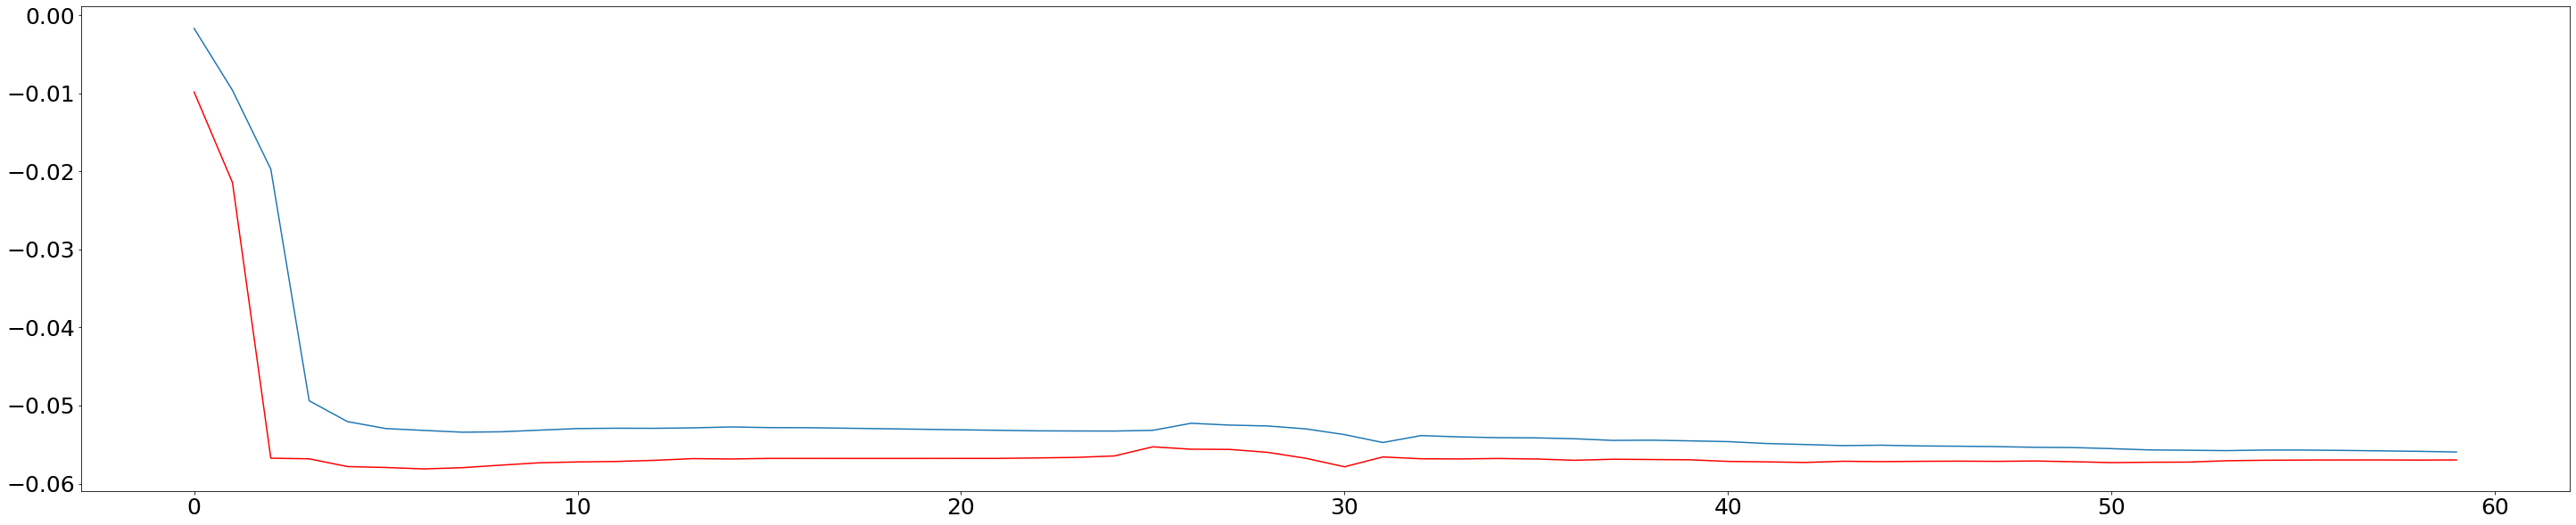

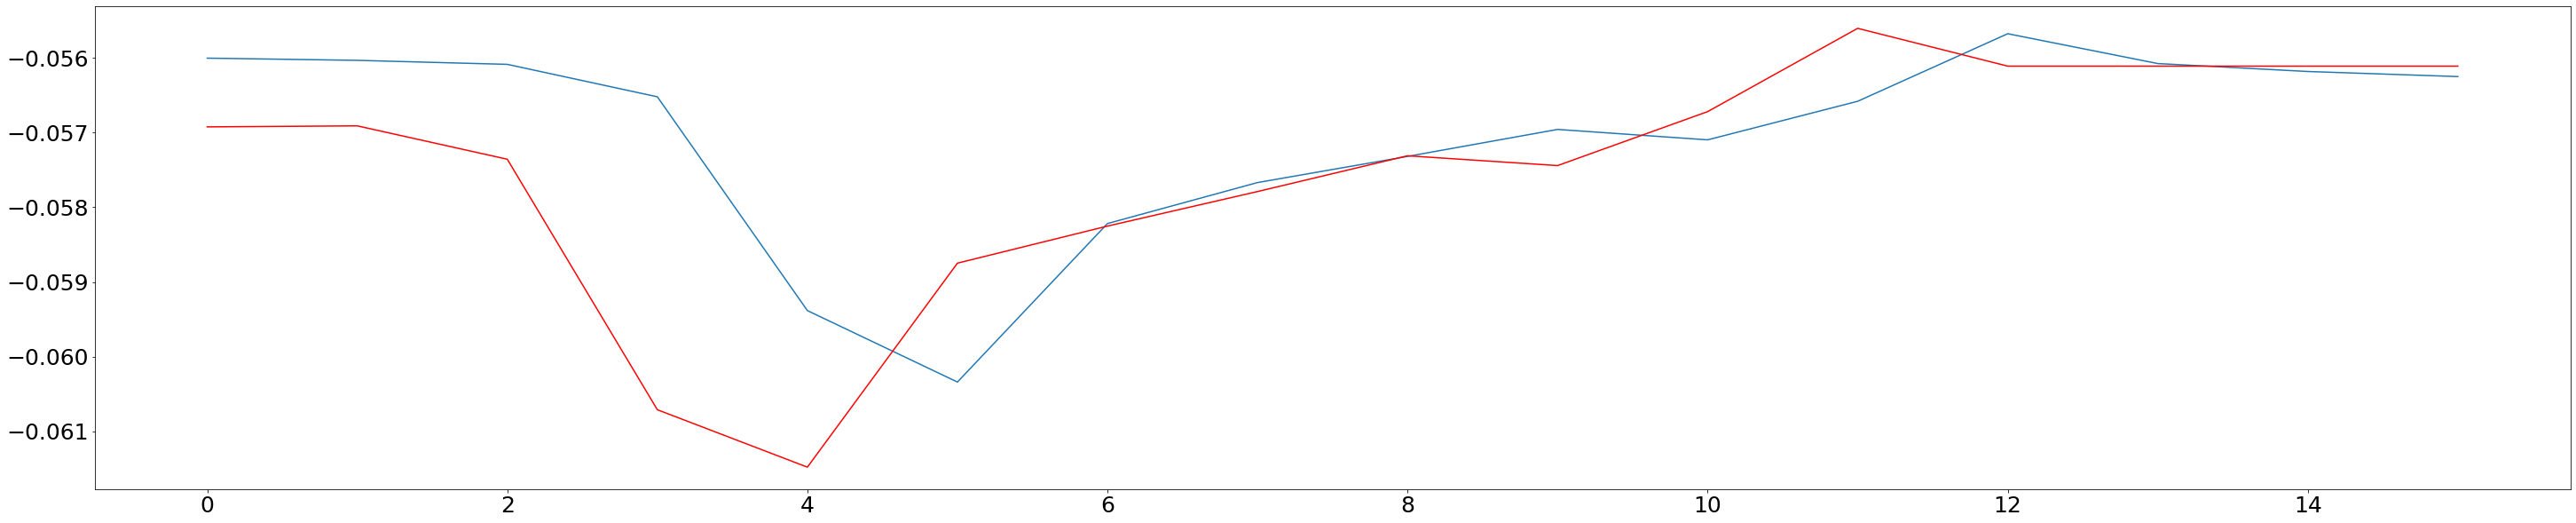

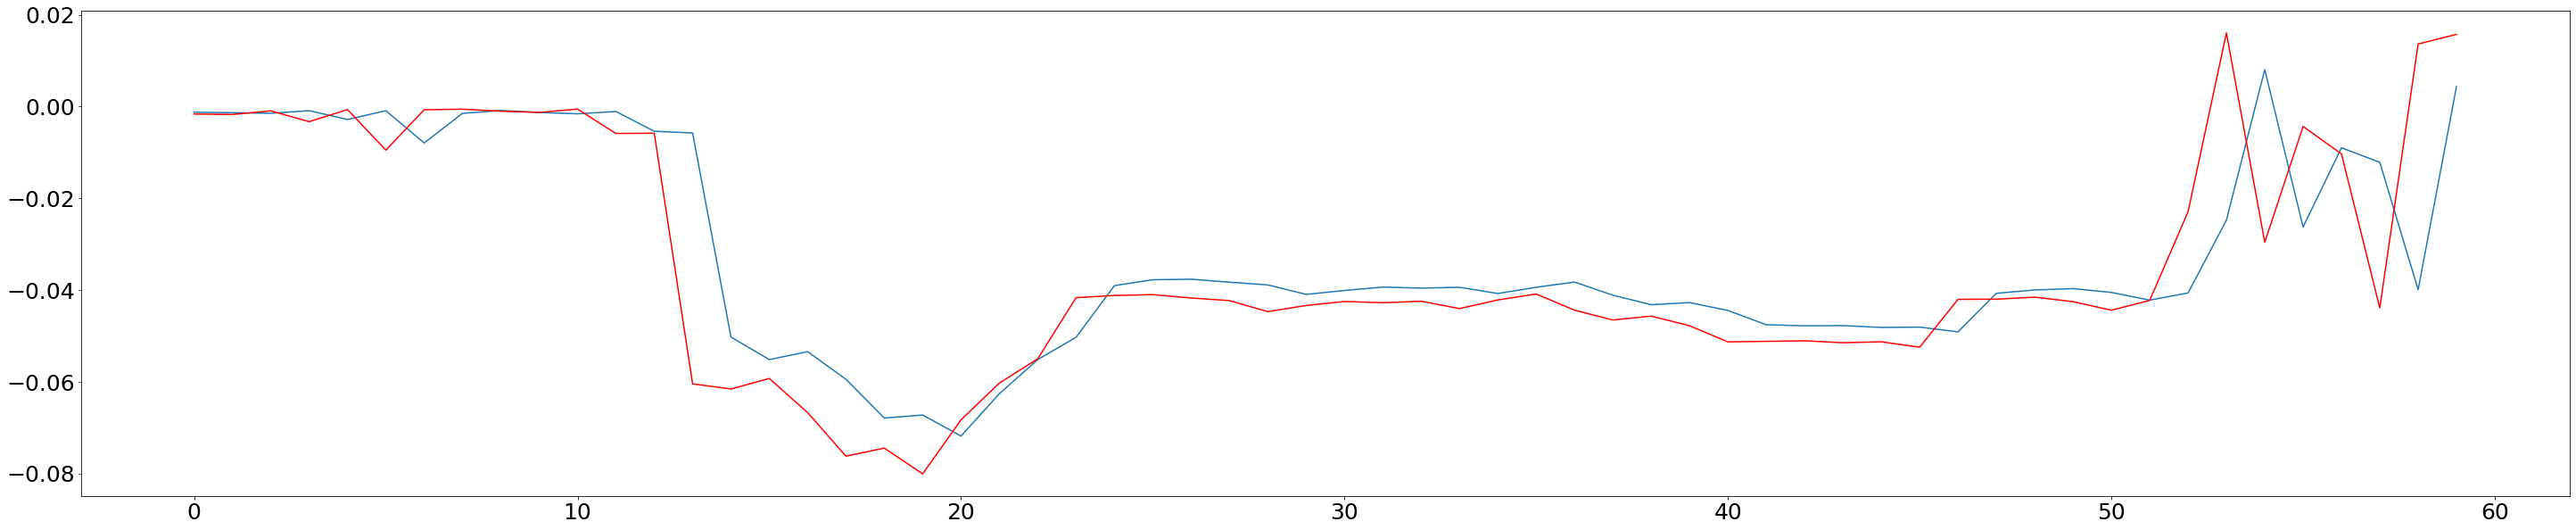

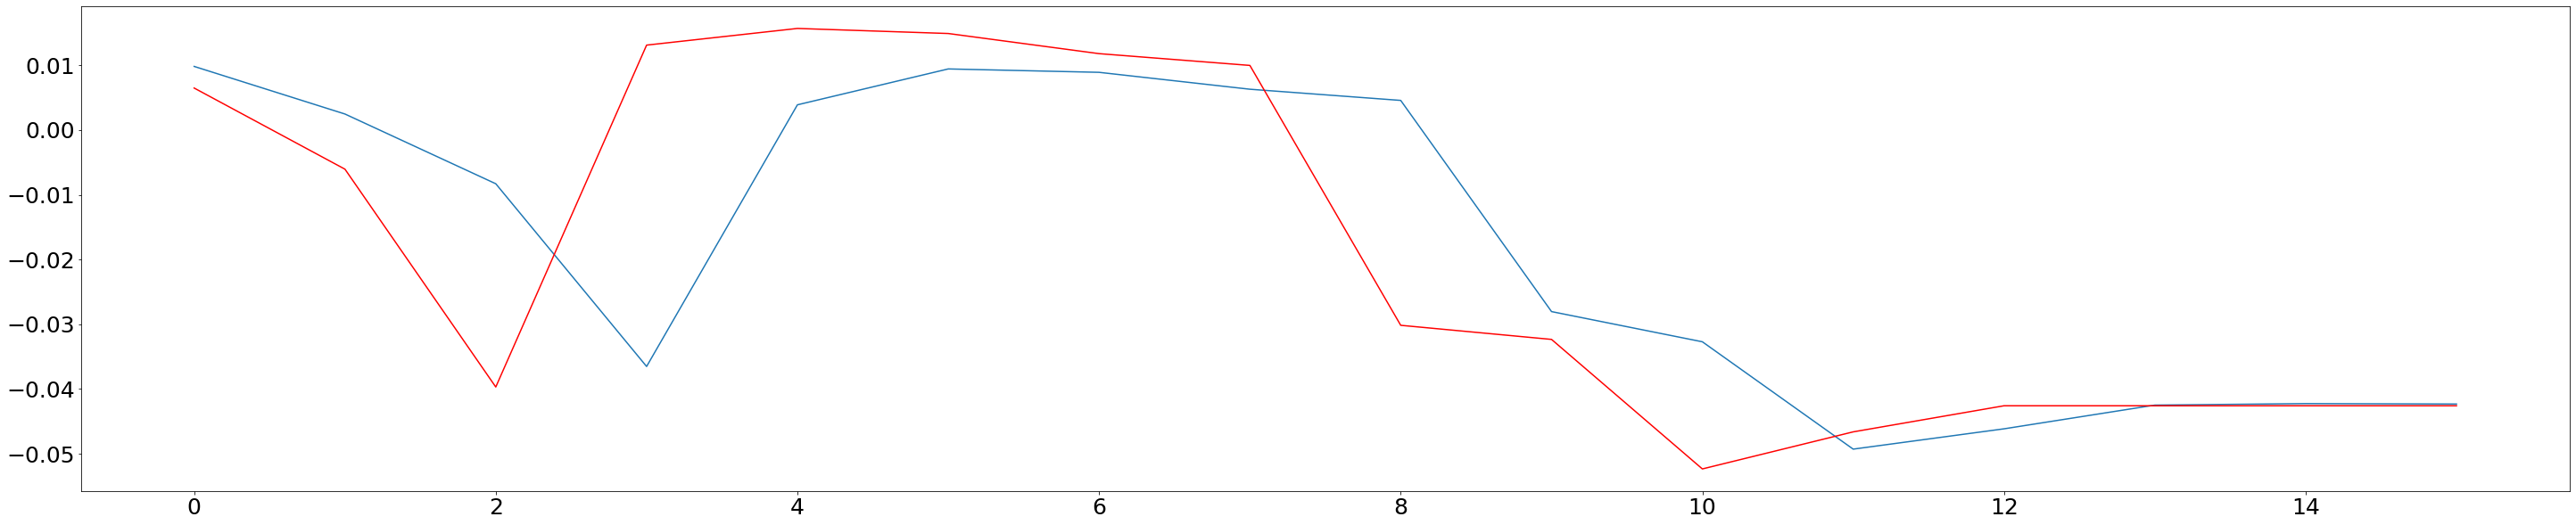

[0.015, 0.0, 0.002, 0.004, 0.004, 0.01, 0.006, 0.001, 0.014, 0.018, 0.005, 0.01]


In [15]:
out = lstm.runModel(units = 350, lookback = 2, batch_size = 1, shuffle = 1)
print(out)

In [ ]:
[0.015, 0.003, 0.003, 0.002, 0.002, 0.01, 0.005, 0.002, 0.014, 0.019, 0.005, 0.01]